In [1]:
import pandas as pd
import numpy as np
import glob
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os

In [2]:
#for filter
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import freqz;

In [3]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

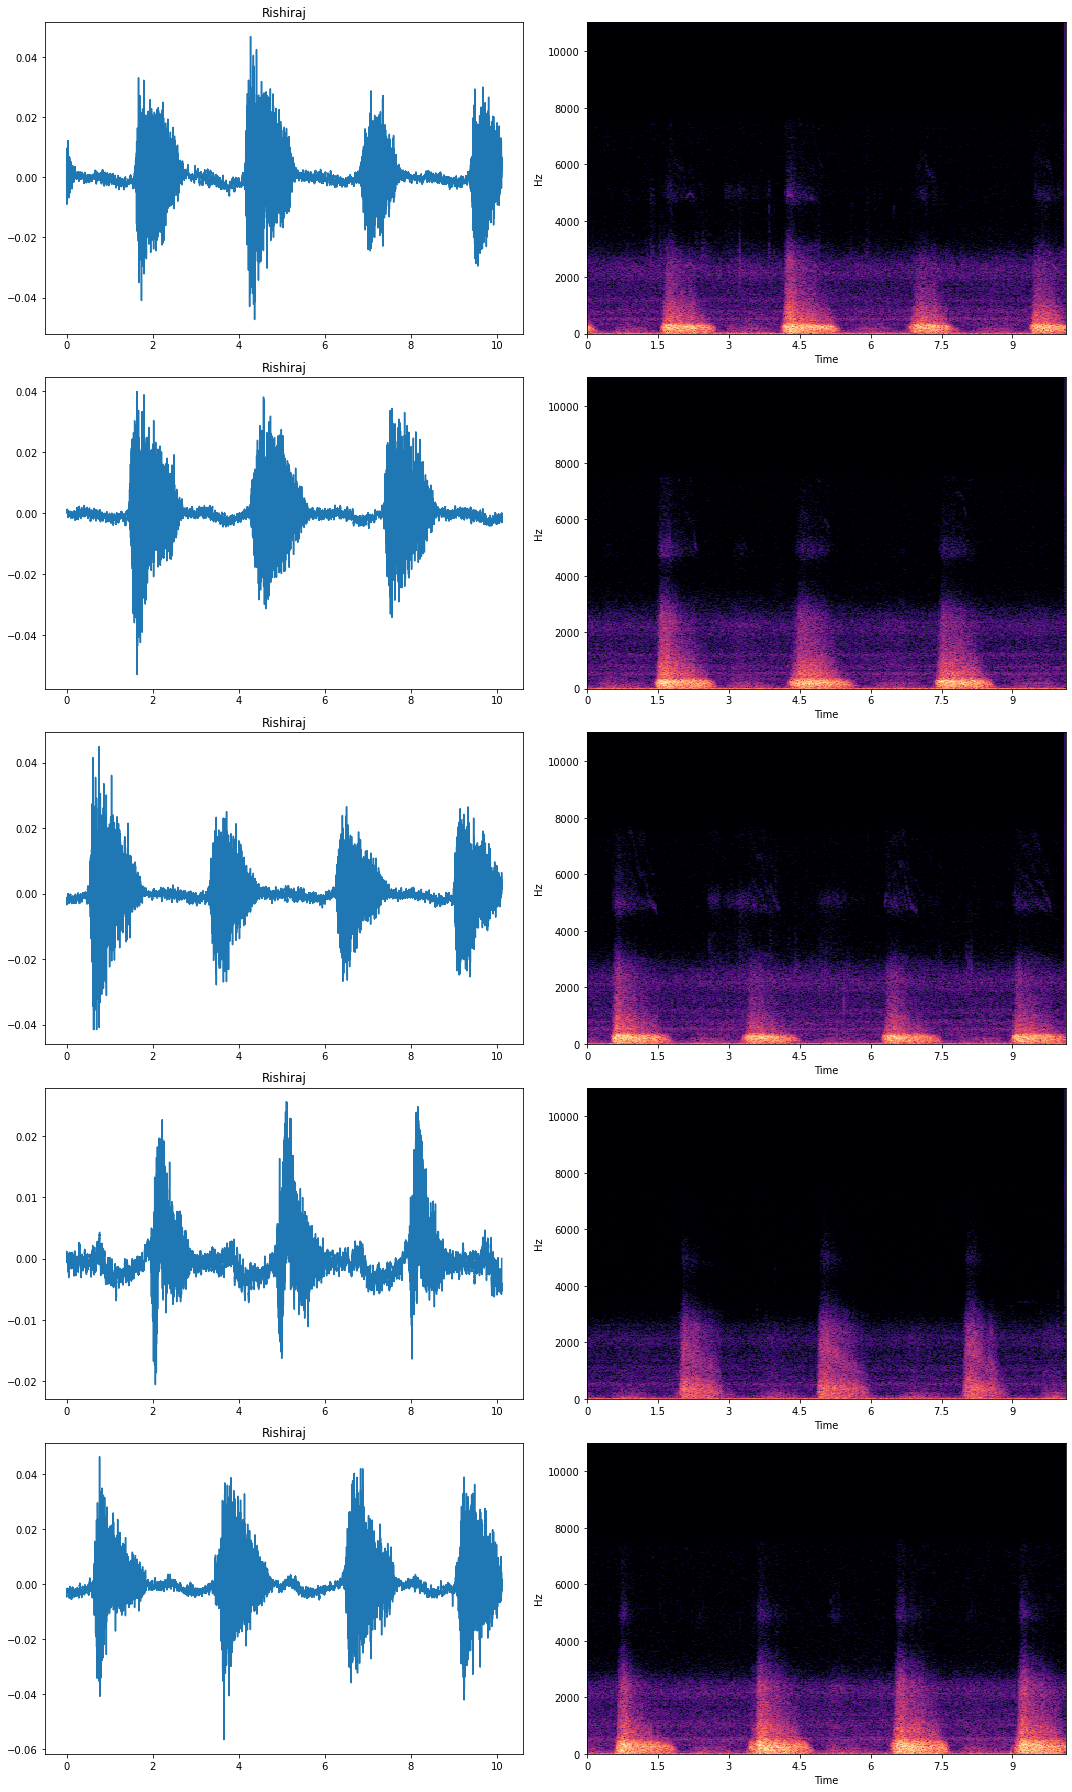

In [11]:
#plot all tidal of Rishi
paths = glob.glob('data/*')
figCount=0;

fig,ax  = plt.subplots(5,2, figsize=(15,25))
for file in paths:
    if os.path.basename(file).split('.')[0] == 'Rishiraj':
        #print(file)
        y, sr = librosa.load(file)



        D = librosa.stft(y)  # STFT of y
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        ax[figCount,0].plot([s/sr for s in range(0,len(y))], y)
        ax[figCount,0].set_title(os.path.basename(file).split('.')[0])
        img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax[figCount,1])
        #fig.colorbar(img, ax=[figCount,1])  
        figCount+=1;
fig.tight_layout()

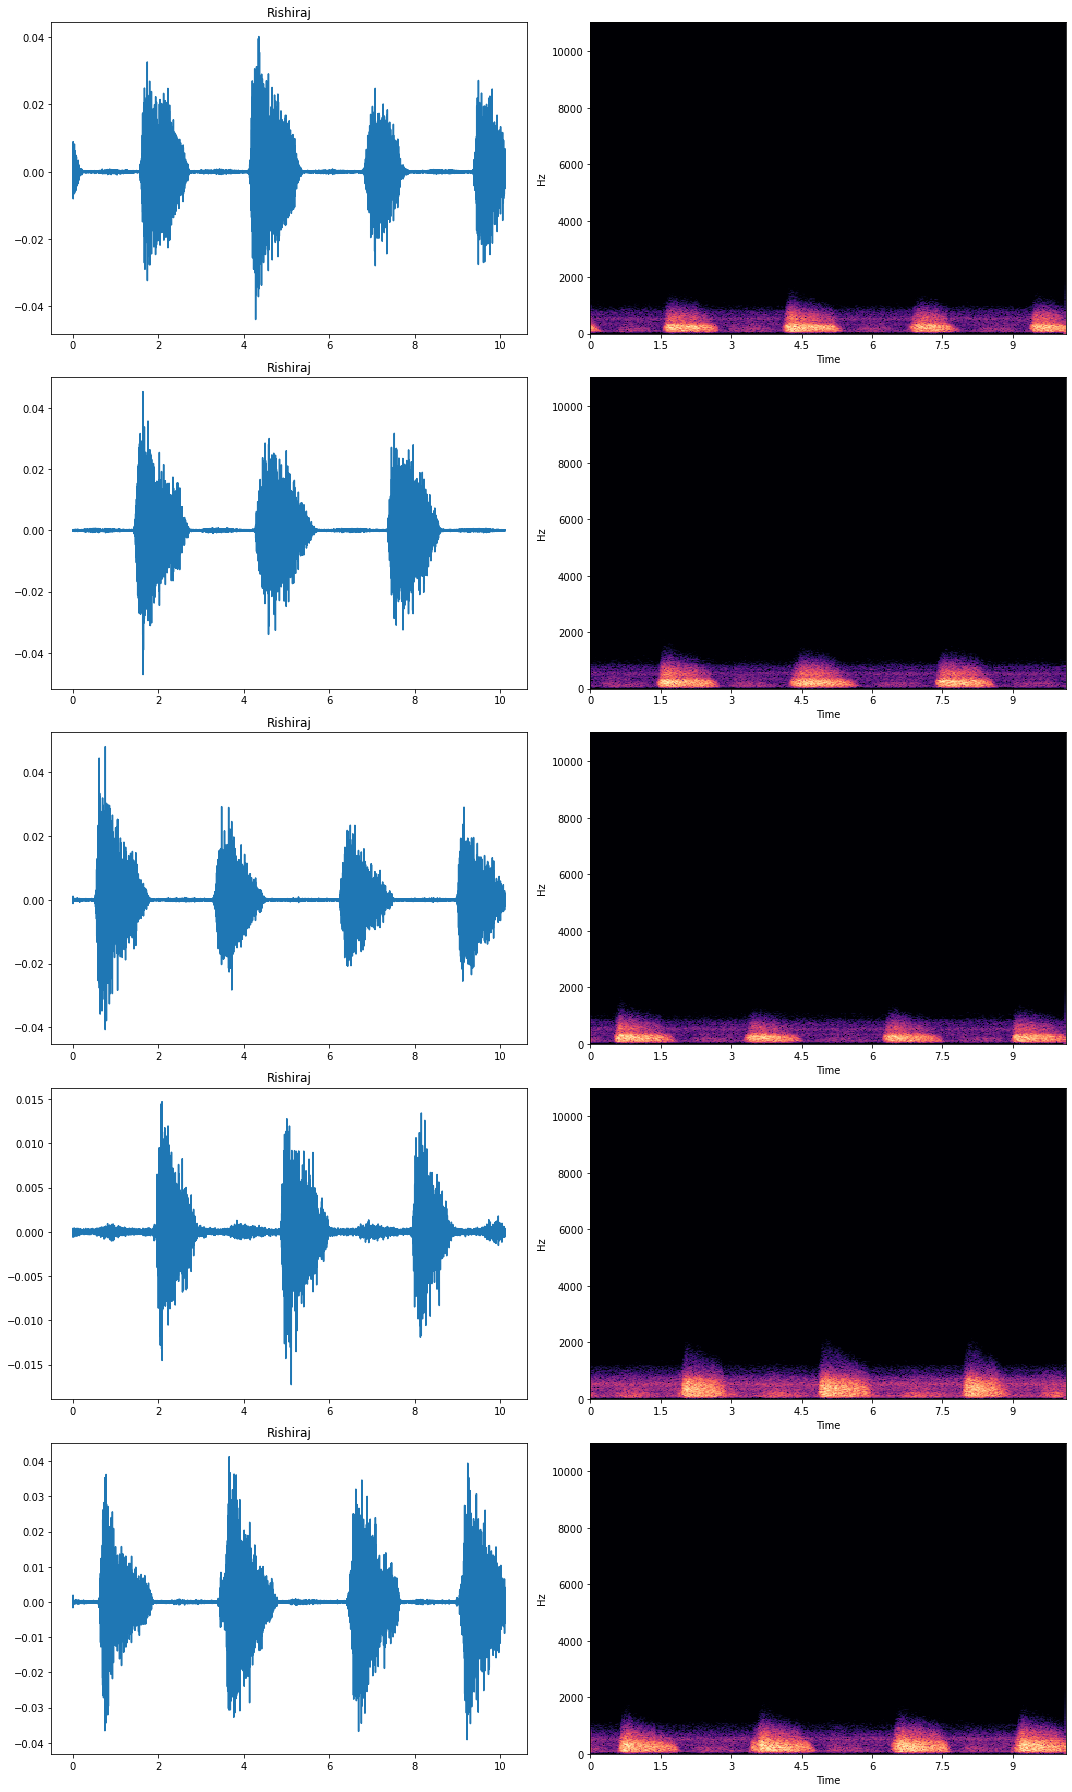

In [28]:
paths = glob.glob('data/*')
t1_list = []
sr_list = []
figCount=0;

#filter params
cutoff_low = 100 
cutoff_high = 700
order = 5
    
fig,ax  = plt.subplots(5,2, figsize=(15,25))
for file in paths:
    if os.path.basename(file).split('.')[0] == 'Rishiraj':
        t1, sr = librosa.load(file)
        #filter the signal
        x_filt = butter_bandpass_filter(t1,cutoff_low,cutoff_high,sr,order)

        D = librosa.stft(x_filt)  # STFT of y
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

        ax[figCount,0].plot([s/sr for s in range(0,len(x_filt))], x_filt)
        ax[figCount,0].set_title(os.path.basename(file).split('.')[0])
        img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax[figCount,1])
    
        figCount+=1;
fig.tight_layout()

In [12]:
import scipy as sp
from scipy import signal

def emd(x, nIMF = 3, stoplim = .001):
    """Perform empirical mode decomposition to extract 'niMF' components out of the signal 'x'."""
    
    r = x
    t = np.arange(len(r))
    imfs = np.zeros(nIMF,dtype=object)
    for i in range(nIMF):
        r_t = r
        is_imf = False
        
        while is_imf == False:
            # Identify peaks and troughs
            pks = sp.signal.argrelmax(r_t)[0]
            trs = sp.signal.argrelmin(r_t)[0]
            
            # Interpolate extrema
            pks_r = r_t[pks]
            fip = sp.interpolate.InterpolatedUnivariateSpline(pks,pks_r,k=3)
            pks_t = fip(t)
            
            trs_r = r_t[trs]
            fitr = sp.interpolate.InterpolatedUnivariateSpline(trs,trs_r,k=3)
            trs_t = fitr(t)
            
            # Calculate mean
            mean_t = (pks_t + trs_t) / 2
            mean_t = _emd_complim(mean_t, pks, trs)
            
            # Assess if this is an IMF (only look in time between peaks and troughs)
            sdk = _emd_comperror(r_t, mean_t, pks, trs)
            
            # if not imf, update r_t and is_imf
            if sdk < stoplim:
                is_imf = True
            else:
                r_t = r_t - mean_t
                
        
        imfs[i] = r_t
        r = r - imfs[i] 
        
    return imfs


def _emd_comperror(h, mean, pks, trs):
    """Calculate the normalized error of the current component"""
    samp_start = np.max((np.min(pks),np.min(trs)))
    samp_end = np.min((np.max(pks),np.max(trs))) + 1
    return np.sum(np.abs(mean[samp_start:samp_end]**2)) / np.sum(np.abs(h[samp_start:samp_end]**2))


def _emd_complim(mean_t, pks, trs):
    samp_start = np.max((np.min(pks),np.min(trs)))
    samp_end = np.min((np.max(pks),np.max(trs))) + 1
    mean_t[:samp_start] = mean_t[samp_start]
    mean_t[samp_end:] = mean_t[samp_end]
    return mean_t

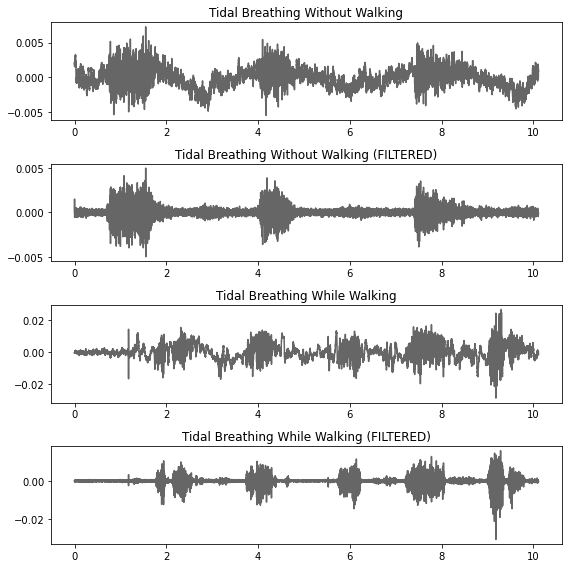

In [21]:
#read tidal breathing and tidal breathing with walking
#filter params
cutoff_low = 100 
cutoff_high = 900
order = 2

tidal, sr = librosa.load('data/Tidal.28okth7i.ingestion-577f6767bd-7248t.wav')
tidalWalking, sr = librosa.load('data/TidalWalking.28p2gda6.wav')

tidal_t = [s/sr for s in range(0,len(tidal))]
tidalWalking_t = [s/sr for s in range(0,len(tidalWalking))]

#filtering using band passfilter
tidal_f = butter_bandpass_filter(tidal,cutoff_low,cutoff_high,sr,order)
tidalWalking_f = butter_bandpass_filter(tidalWalking,cutoff_low,cutoff_high,sr,order)

fig, ax = plt.subplots(4,1,figsize=(8,8))
ax[0].plot(tidal_t, tidal,'k', alpha=0.6);
ax[0].set_title('Tidal Breathing Without Walking')
ax[1].plot(tidal_t, tidal_f,'k', alpha=0.6)
ax[1].set_title('Tidal Breathing Without Walking (FILTERED)')
ax[2].plot(tidalWalking_t, tidalWalking,'k', alpha=0.6);
ax[2].set_title('Tidal Breathing While Walking')
ax[3].plot(tidalWalking_t, tidalWalking_f,'k', alpha=0.6)
ax[3].set_title('Tidal Breathing While Walking (FILTERED)')
fig.tight_layout()

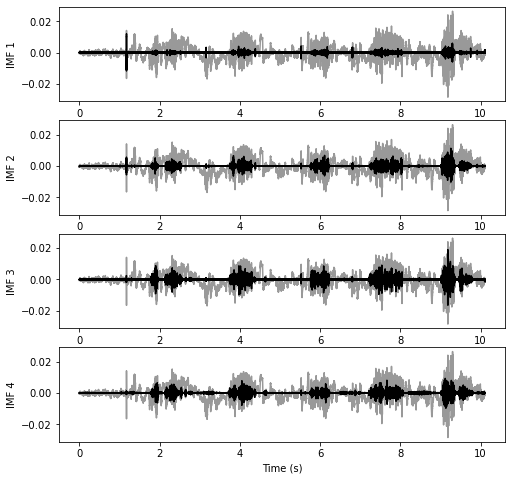

In [25]:
imfs = emd(y, nIMF = 4)
fig, ax = plt.subplots(len(imfs),1, figsize=(8,8))
for i in range(len(imfs)):
    ax[i].plot(t,y,color='0.6')
    ax[i].plot(t,imfs[i],'k')
    ax[i].set_ylabel('IMF '+np.str(i+1))
    if i == len(imfs)-1:
        plt.xlabel('Time (s)')